In [2]:
#pip install xgboost
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

In [4]:
### Darts: Time Series Made Easy in Python
from darts import TimeSeries
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode
from darts.metrics import mape
from darts.utils.statistics import plot_residuals_analysis
from darts.models import XGBModel

import optuna

In [5]:
path_weekly = "../../SRAG_time_series/SRAG_TS_weekly.csv"
path_daily = "../../SRAG_time_series/SRAG_TS.csv"

df_weekly  = pd.read_csv(path_weekly, sep=",", encoding="latin-1")
df_daily = pd.read_csv(path_daily, sep=",", encoding="latin-1")

In [6]:
df_weekly["Year_Week"] = pd.to_datetime(df_weekly["Year_Week"])
df_daily["Date"] = pd.to_datetime(df_daily["Date"])
df_weekly = df_weekly.sort_values('Year_Week')

In [10]:
#df_weekly = df_weekly.set_index("Year_Week")
df_weekly.drop(columns=['week'], inplace=True)
df_weekly = df_weekly.iloc[1:]
df_weekly

,Year_Week,Number_Cases
1,2019-01-07,256.0
2,2019-01-14,270.0
3,2019-01-21,273.0
4,2019-01-28,282.0
5,2019-02-04,300.0
...,...,...
313,2024-12-02,4298.0
314,2024-12-09,4284.0
315,2024-12-16,4028.0
316,2024-12-23,4028.0


In [12]:
df_weekly = df_weekly.drop_duplicates(subset='Year_Week', keep='first')

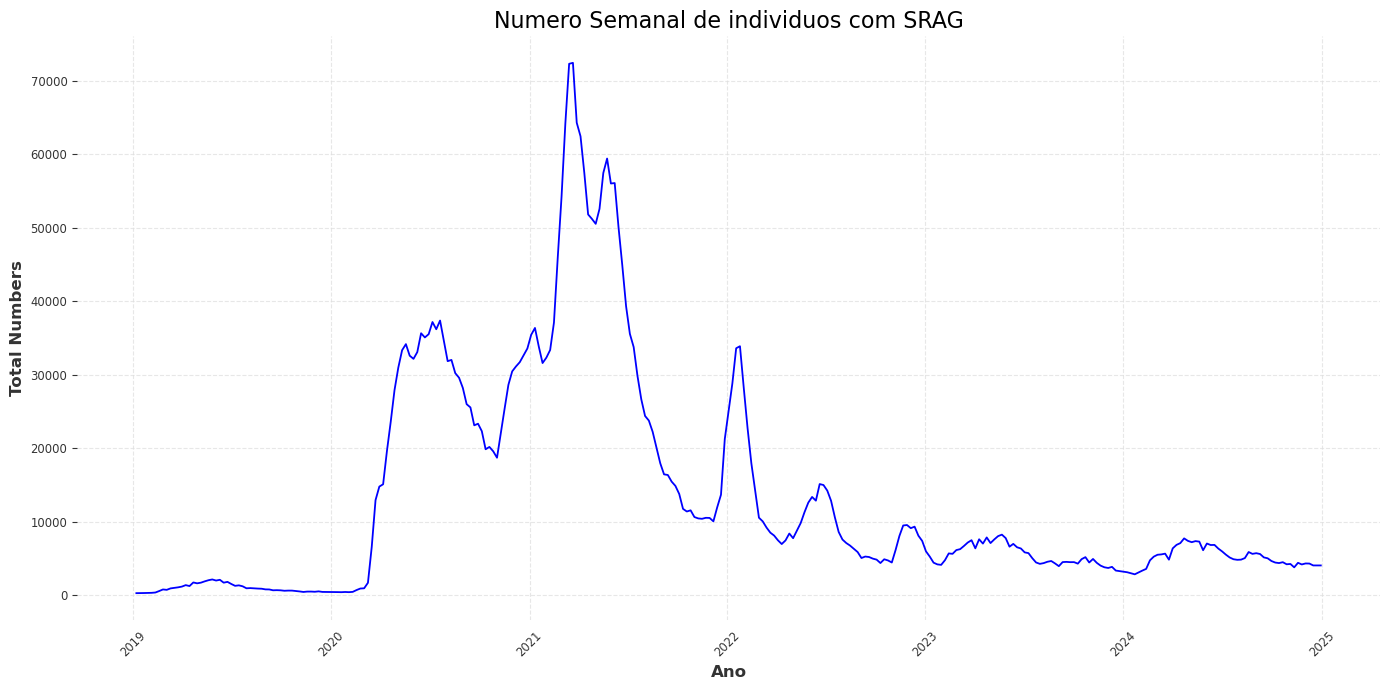

In [14]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_weekly, x='Year_Week', y='Number_Cases', color='b')
#sns.lineplot(data=df_daily, x='Number', y='Number', color='b')


# Customize the plot
plt.title('Numero Semanal de individuos com SRAG', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Total Numbers', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Transformando em TimeSeries da darts

In [16]:
full_index = pd.date_range(start=df_weekly['Year_Week'].min(),
                           end=df_weekly['Year_Week'].max(),
                           freq='W-MON')

missing = full_index.difference(df_weekly['Year_Week'])
print("Missing weeks:", missing)


Missing weeks: DatetimeIndex([], dtype='datetime64[ns]', freq='W-MON')


In [18]:
non_mondays = df_weekly[~(df_weekly['Year_Week'].dt.weekday == 0)]
print(non_mondays)

    Year_Week  Number_Cases
53 2020-01-01         414.5


In [20]:
df_weekly['Year_Week'] = df_weekly['Year_Week'] - pd.to_timedelta(df_weekly['Year_Week'].dt.weekday, unit='d')

C:\Users\aryck\AppData\Local\Temp\ipykernel_47900\3759238453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Year_Week'] = df_weekly['Year_Week'] - pd.to_timedelta(df_weekly['Year_Week'].dt.weekday, unit='d')


In [22]:
df_weekly = df_weekly.groupby('Year_Week', as_index=False)['Number_Cases'].sum()

In [24]:
series_weekly = TimeSeries.from_dataframe(
    df_weekly,
    time_col='Year_Week',
    value_cols='Number_Cases',
    fill_missing_dates=True,
    freq='W-MON'
)

<Axes: xlabel='Year_Week'>

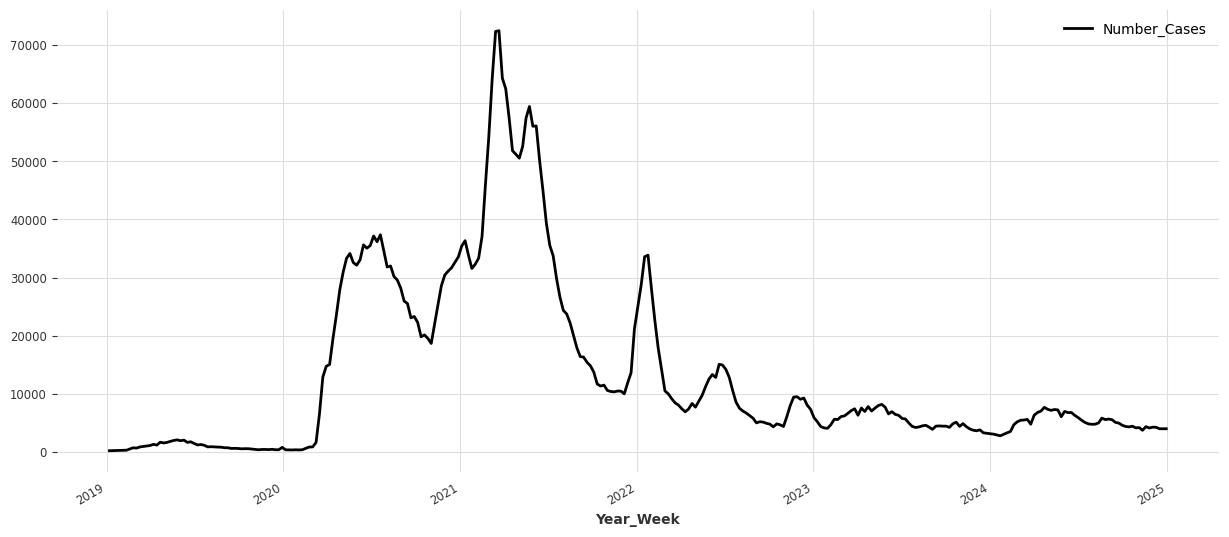

In [26]:
figure = plt.figure(figsize = (15,6))
series_weekly.plot()

In [30]:
import pickle

# Salvando no formato .pkl
with open("series_weekly_SRAG.pkl", "wb") as f:
    pickle.dump(series_weekly, f)

### Train Test Split

In [29]:
def train_test_splits(series, train_proportion_list):
    '''
    Funcao para dividir a serie temporal em treino e teste
    
    Parametros:
    
    *series: serie que sera particionada em treino e validacao.
    *train_proportion_list: Lista que define a proporcao do conjunto
    de treinamento. Ex: series_list = [0.8,0.5] significa primeiro conjunto 
    de treino com 80% dos dados totais e o segundo com 50% dos dados totais.
    '''
    partitions_dict = {'train': [], 'test': []}

    for i, train_proportion in enumerate(train_proportion_list):
        train_size = int(len(series) * train_proportion)
        train, test = series.split_before(train_size)
        partitions_dict['train'].append(train)
        partitions_dict['test'].append(test)

        print(f'Partition {i+1} - Train size: {len(train)}, Test size: {len(test)}, Total size: {len(train)+len(test)}')

    return partitions_dict

In [37]:
train_test_df_weekly = train_test_splits(series_weekly, [0.83])

train_83 = train_test_df_weekly['train'][0]
test_17 = train_test_df_weekly['test'][0]

Partition 1 - Train size: 259, Test size: 54, Total size: 313


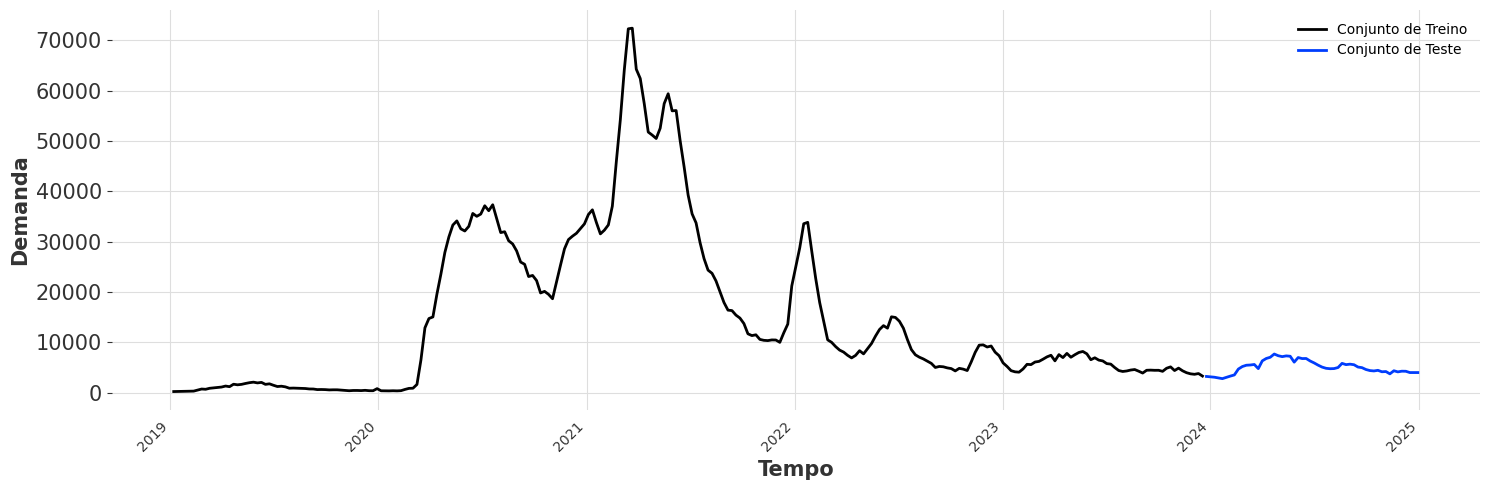

In [33]:
## Plotando
plt.figure(figsize=(15, 5))

train_test_df_weekly['train'][0].plot(label='Conjunto de Treino')

train_test_df_weekly['test'][0].plot(label='Conjunto de Teste')

plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=15)
plt.xlabel('Tempo', fontsize=15)
plt.ylabel('Demanda', fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()

### XGBoost Model

In [61]:
model = XGBModel(
    lags=24,  # use past 12 values as features
    output_chunk_length=5
)

# Fit the model
model.fit(train_83)

# Predict next 24 weeks
prediction = model.predict(n=300)

In [63]:
mape_pred = mape(test_17 ,prediction)
mape_pred

51.040368781774134

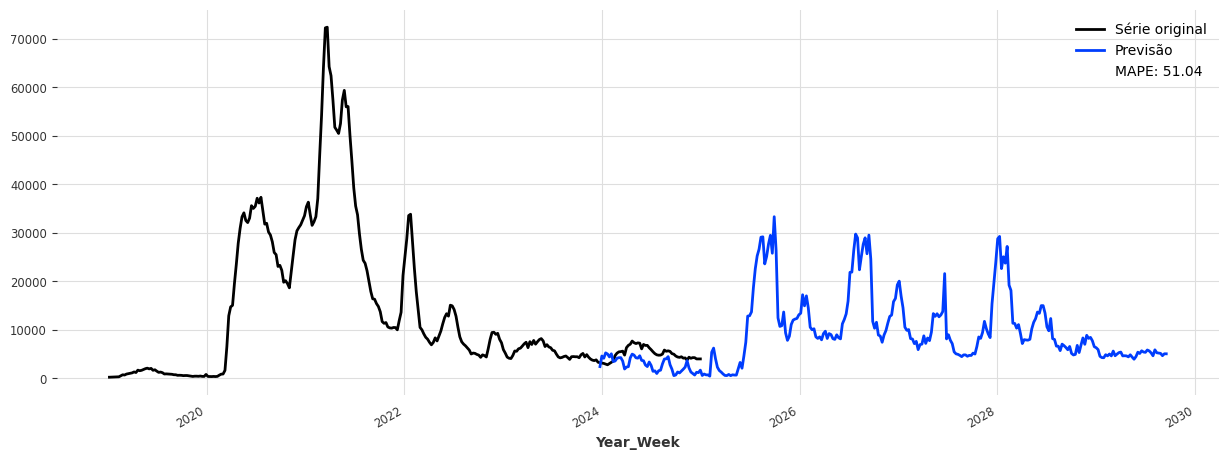

In [65]:
fig = plt.figure(figsize=(15,5))
series_weekly.plot(label='Série original')
prediction.plot(label='Previsão')
plt.plot([],[],' ',label=f'MAPE: {round(mape_pred,2)}')
plt.legend()
plt.show()

### Setup de treinamento com OPTUNA (XGBoost Model)

In [71]:
# Define objective function for Optuna
def objective(trial):
    params = {
        "lags": trial.suggest_int("lags", 1, 36),
        "output_chunk_length": trial.suggest_int("output_chunk_length", 1, 12),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 1),
    }
    
    # Initialize model
    model = XGBModel(
        lags=params["lags"],
        output_chunk_length=params["output_chunk_length"],
        random_state=42,
        **{k: v for k, v in params.items() if k not in ["lags", "output_chunk_length"]}
    )

    # Fit model
    model.fit(
        series=train_83,
        verbose=False
    )
    
    # Evaluate on validation set
    preds = model.predict(
        n=len(test_17),
    )
    
    # Return MAPE (we minimize this)
    return mape(test_17, preds)

In [73]:
# Create study and optimize
study = optuna.create_study(direction="minimize")

# Global variable to store best model
best_model = None

[I 2025-05-09 14:50:06,846] A new study created in memory with name: no-name-d0d86e10-1278-4ed4-a7e8-710c1b0b35f6


In [75]:
# Callback to save best model
def callback(study, trial):
    global best_model
    if study.best_trial.number == trial.number:
        best_params = trial.params
        best_model = XGBModel(
            lags=best_params["lags"],
            output_chunk_length=best_params["output_chunk_length"],
            random_state=42,
            **{k: v for k, v in best_params.items() if k not in ["lags", "output_chunk_length"]}
        )
        best_model.fit(series=train_83)

# Run optimization
study.optimize(objective, n_trials=30, callbacks=[callback], show_progress_bar=True)

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-05-09 14:52:24,240] Trial 0 finished with value: 27.272847610264495 and parameters: {'lags': 21, 'output_chunk_length': 5, 'n_estimators': 345, 'max_depth': 6, 'learning_rate': 0.09168834460446103, 'subsample': 0.7871290250351489, 'colsample_bytree': 0.6477688165112219, 'min_child_weight': 10, 'gamma': 0.1113051881623871}. Best is trial 0 with value: 27.272847610264495.
[I 2025-05-09 14:52:29,408] Trial 1 finished with value: 30.57975145101649 and parameters: {'lags': 35, 'output_chunk_length': 7, 'n_estimators': 248, 'max_depth': 10, 'learning_rate': 0.017478772101898254, 'subsample': 0.6309613873392426, 'colsample_bytree': 0.8262860349379193, 'min_child_weight': 10, 'gamma': 0.814193205719268}. Best is trial 0 with value: 27.272847610264495.
[I 2025-05-09 14:52:30,323] Trial 2 finished with value: 213.48371644624342 and parameters: {'lags': 31, 'output_chunk_length': 11, 'n_estimators': 129, 'max_depth': 3, 'learning_rate': 0.0030174968555895833, 'subsample': 0.64387753828499

In [83]:
# Results
print("Best trial:")
trial = study.best_trial
print(f"MAPE: {trial.value:.2f}%")
print("Best params:")
for key, value in trial.params.items():
    print(f"{key}: {value}")

# Generate forecast
forecast = best_model.predict(n=100)  # 3 years ahead

Best trial:
MAPE: 21.39%
Best params:
lags: 36
output_chunk_length: 3
n_estimators: 424
max_depth: 4
learning_rate: 0.011528969135060648
subsample: 0.7248933636678442
colsample_bytree: 0.8530481814925535
min_child_weight: 2
gamma: 0.5826653850716775


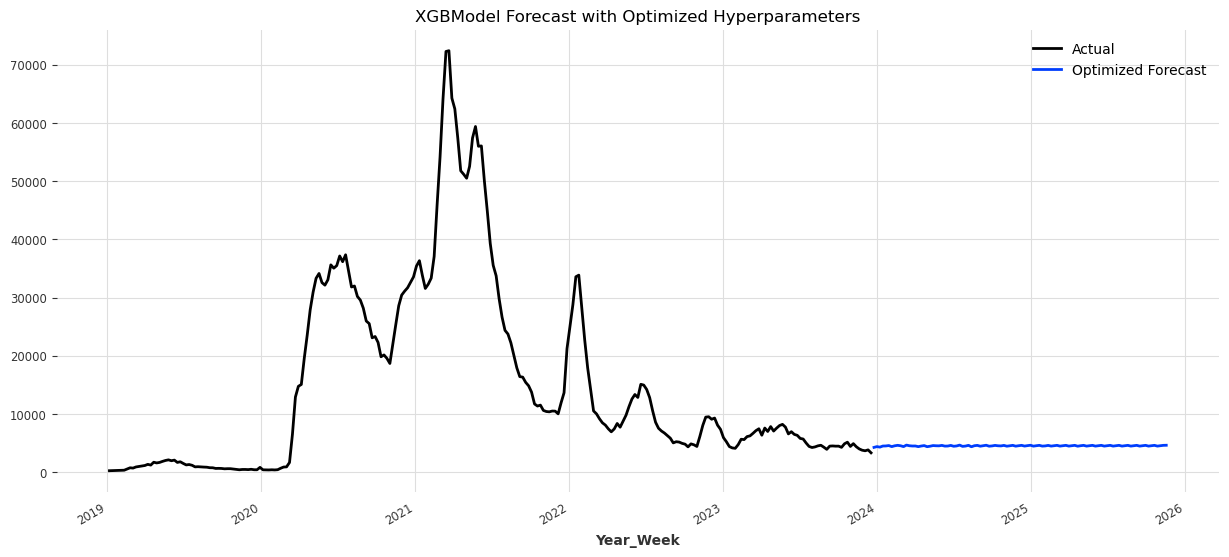

In [91]:
# Visualization
plt.figure(figsize=(15, 6))
train_83.plot(label="Actual")
forecast.plot(label="Optimized Forecast")
plt.title("XGBModel Forecast with Optimized Hyperparameters")
plt.legend()
plt.show()